In [ ]:
!pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile
from typing import List, Union
import pandas as pd
from tqdm import tqdm

from pydriller import Repository
from pydriller.domain.commit import ModificationType
from pydriller.git import Git
from git import Repo, GitCommandError

def ensure_local_checkout(repo_spec: str, base_dir: str) -> str:
    """
    repo_spec: can be a local path or a remote URL.
    Returns a local path with a valid git repo.
    """
    if os.path.isdir(repo_spec) and os.path.isdir(os.path.join(repo_spec, ".git")):
        return os.path.abspath(repo_spec)

    target = os.path.join(base_dir, os.path.basename(repo_spec.rstrip("/")).replace(".git", ""))
    if os.path.exists(target):
        shutil.rmtree(target)
    Repo.clone_from(repo_spec, target)
    return target

In [ ]:
def get_git_diffs(repo_path: str, parent_sha: str, commit_sha: str, file_path: str) -> dict:
    """
    Return diffs with whitespace and blank lines ignored:
    - Myers (default algorithm)
    - Histogram
    """
    repo = Repo(repo_path)
    rel_path = file_path

    def run_diff(args: List[str]) -> str:
        try:
            return repo.git.diff(
                parent_sha, commit_sha,
                *args,
                "--", rel_path
            )
        except GitCommandError:
            return ""

    common_flags = ["-w", "--ignore-blank-lines"]

    myers = run_diff(common_flags + ["--diff-algorithm=myers"])
    hist  = run_diff(common_flags + ["--diff-algorithm=histogram"])

    return {"diff_myers": myers, "diff_hist": hist}

In [ ]:
def mine_repos(repo_list, output_csv: str = "consolidated_pydriller.csv"):
    rows = []
    with tempfile.TemporaryDirectory() as tmpdir:
        local_paths = [ensure_local_checkout(r, tmpdir) for r in repo_list]

        for repo_path in local_paths:
            for commit in tqdm(
                Repository(
                    repo_path,
                    only_modifications_with_file_types=['.py'] 
                ).traverse_commits(),
                desc=f"Mining {os.path.basename(repo_path)}"
            ):
                if not commit.parents:
                    continue

                parent_sha = commit.parents[0]  

                for m in commit.modified_files:
                    if m.change_type != ModificationType.MODIFY:
                        continue

                    if getattr(m, "is_binary", False):
                        continue

                    old_path = m.old_path or m.new_path
                    new_path = m.new_path or m.old_path
                    file_for_diff = new_path or old_path
                    if file_for_diff is None:
                        continue

                    diffs = get_git_diffs(repo_path, parent_sha, commit.hash, file_for_diff)

                    rows.append({
                        "old_file_path": old_path,
                        "new_file_path": new_path,
                        "commit_sha": commit.hash,
                        "parent_commit_sha": parent_sha,
                        "commit_message": (commit.msg or "").strip(),
                        "diff_myers": diffs["diff_myers"],
                        "diff_hist": diffs["diff_hist"],
                        "repo": os.path.basename(repo_path),
                        "commit_author_date": commit.author_date.isoformat()
                    })

    df = pd.DataFrame(rows, columns=[
        "old_file_path", "new_file_path",
        "commit_sha", "parent_commit_sha",
        "commit_message", "diff_myers", "diff_hist",
        "repo", "commit_author_date"
    ])
    df.to_csv(output_csv, index=False)
    print(f"Consolidated CSV saved to:{output_csv}")
    return df

In [ ]:
repos = [
    "https://github.com/Aider-AI/aider.git",
    "https://github.com/aws/aws-cli.git",
    "https://github.com/apache/airflow.git",
]
mine_repos(repos, output_csv="all_repos_consolidated.csv")

Mining aider: 7930it [02:24, 54.77it/s]
Mining aws-cli: 4805it [04:34, 17.51it/s]
Mining airflow: 22067it [27:34, 13.33it/s]


✅ Done! Consolidated CSV saved to: all_repos_consolidated.csv  | Rows: 185821


,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,repo,commit_author_date
0,coder.py,coder.py,6fc98423c61c0986b5c1c16551ade3488bf2be19,41aed411ea2ba2544d10f23ec30d6089056e8953,better,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,aider,2023-04-03T21:31:37-07:00
1,coder.py,coder.py,1f4706e0e7bca69458a0f294375fb53868589919,6fc98423c61c0986b5c1c16551ade3488bf2be19,worked,diff --git a/coder.py b/coder.py\nindex 06632e...,diff --git a/coder.py b/coder.py\nindex 06632e...,aider,2023-04-03T21:41:46-07:00
2,coder.py,coder.py,62c41c6b5b549f26e5ab8f99dac61671ba90d218,1f4706e0e7bca69458a0f294375fb53868589919,better,diff --git a/coder.py b/coder.py\nindex 7c9da4...,diff --git a/coder.py b/coder.py\nindex 7c9da4...,aider,2023-04-03T21:46:56-07:00
3,coder.py,coder.py,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,62c41c6b5b549f26e5ab8f99dac61671ba90d218,does not work,diff --git a/coder.py b/coder.py\nindex 25c16b...,diff --git a/coder.py b/coder.py\nindex 25c16b...,aider,2023-04-03T22:11:03-07:00
4,coder.py,coder.py,692e649c3fbf7645a0161f6d132b5725e68dcb3c,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,works,diff --git a/coder.py b/coder.py\nindex d0133e...,diff --git a/coder.py b/coder.py\nindex d0133e...,aider,2023-04-03T22:32:13-07:00
...,...,...,...,...,...,...,...,...,...
185816,task-sdk/src/airflow/sdk/definitions/connectio...,task-sdk/src/airflow/sdk/definitions/connectio...,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/definiti...,diff --git a/task-sdk/src/airflow/sdk/definiti...,airflow,2025-08-26T09:23:53-07:00
185817,task-sdk/src/airflow/sdk/execution_time/comms.py,task-sdk/src/airflow/sdk/execution_time/comms.py,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,airflow,2025-08-26T09:23:53-07:00
185818,task-sdk/src/airflow/sdk/execution_time/contex...,task-sdk/src/airflow/sdk/execution_time/contex...,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,airflow,2025-08-26T09:23:53-07:00
185819,task-sdk/tests/task_sdk/bases/test_hook.py,task-sdk/tests/task_sdk/bases/test_hook.py,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/tests/task_sdk/bases/tes...,diff --git a/task-sdk/tests/task_sdk/bases/tes...,airflow,2025-08-26T09:23:53-07:00


In [ ]:
df

,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,repo,commit_author_date
0,coder.py,coder.py,6fc98423c61c0986b5c1c16551ade3488bf2be19,41aed411ea2ba2544d10f23ec30d6089056e8953,better,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,aider,2023-04-03T21:31:37-07:00
1,coder.py,coder.py,1f4706e0e7bca69458a0f294375fb53868589919,6fc98423c61c0986b5c1c16551ade3488bf2be19,worked,diff --git a/coder.py b/coder.py\nindex 06632e...,diff --git a/coder.py b/coder.py\nindex 06632e...,aider,2023-04-03T21:41:46-07:00
2,coder.py,coder.py,62c41c6b5b549f26e5ab8f99dac61671ba90d218,1f4706e0e7bca69458a0f294375fb53868589919,better,diff --git a/coder.py b/coder.py\nindex 7c9da4...,diff --git a/coder.py b/coder.py\nindex 7c9da4...,aider,2023-04-03T21:46:56-07:00
3,coder.py,coder.py,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,62c41c6b5b549f26e5ab8f99dac61671ba90d218,does not work,diff --git a/coder.py b/coder.py\nindex 25c16b...,diff --git a/coder.py b/coder.py\nindex 25c16b...,aider,2023-04-03T22:11:03-07:00
4,coder.py,coder.py,692e649c3fbf7645a0161f6d132b5725e68dcb3c,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,works,diff --git a/coder.py b/coder.py\nindex d0133e...,diff --git a/coder.py b/coder.py\nindex d0133e...,aider,2023-04-03T22:32:13-07:00
...,...,...,...,...,...,...,...,...,...
185816,task-sdk/src/airflow/sdk/definitions/connectio...,task-sdk/src/airflow/sdk/definitions/connectio...,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/definiti...,diff --git a/task-sdk/src/airflow/sdk/definiti...,airflow,2025-08-26T09:23:53-07:00
185817,task-sdk/src/airflow/sdk/execution_time/comms.py,task-sdk/src/airflow/sdk/execution_time/comms.py,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,airflow,2025-08-26T09:23:53-07:00
185818,task-sdk/src/airflow/sdk/execution_time/contex...,task-sdk/src/airflow/sdk/execution_time/contex...,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,airflow,2025-08-26T09:23:53-07:00
185819,task-sdk/tests/task_sdk/bases/test_hook.py,task-sdk/tests/task_sdk/bases/test_hook.py,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/tests/task_sdk/bases/tes...,diff --git a/task-sdk/tests/task_sdk/bases/tes...,airflow,2025-08-26T09:23:53-07:00


In [ ]:
df["diff_myers"][0]

'diff --git a/coder.py b/coder.py\nindex 2c15ceb7..06632e68 100755\n--- a/coder.py\n+++ b/coder.py\n@@ -18,10 +18,8 @@ openai.api_key = os.getenv("OPENAI_API_KEY")\n \n prompt_webdev = \'\'\'\n I want you to act as a web development expert.\n-I want you to answer only with code.\n-Make the requested change to the provided code and output the changed code.\n-MAKE NO OTHER CHANGES!\n-Do not provide explanations!\n+You are to carefully study the provided code and follow the user instructions.\n+Be detail oriented, explicit and thorough in following user instructions.\n \'\'\'\n \n class Chat:\n@@ -33,8 +31,20 @@ class Chat:\n     def request(self, prompt):\n         self.request_prompt = prompt\n \n-    def run(self):\n-        prompt = self.request_prompt + \'\\n###\\n\'\n+    def plan(self):\n+        prompt = \'\'\'\n+Briefly describe all the code changes needed to complete the user request.\n+Think carefully about the code and the request!\n+Just describe ALL the changes needed to com

In [ ]:
import pandas as pd
import difflib

def normalize_diff(text: str) -> str:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    norm_lines = []
    for line in text.splitlines():
        stripped_right = line.rstrip()         
        if stripped_right.strip() == "":        
            continue
        norm_lines.append(stripped_right)
    return "\n".join(norm_lines)

df["discrepancy_strict"] = df["diff_myers"] != df["diff_hist"]

df["norm_myers"] = df["diff_myers"].apply(normalize_diff)
df["norm_hist"] = df["diff_hist"].apply(normalize_diff)
df["discrepancy"] = df["norm_myers"] != df["norm_hist"]   

def ndiff_report(myers: str, hist: str):
    m_lines = (myers or "").splitlines()
    h_lines = (hist or "").splitlines()
    return list(difflib.ndiff(m_lines, h_lines))

mismatch_rows = df[df["discrepancy"]].copy()
if not mismatch_rows.empty:
    details = []
    for idx, row in mismatch_rows.iterrows():
        for mark in ndiff_report(row["norm_myers"], row["norm_hist"]):
            details.append({
                "row_index": idx,
                "marker": mark[:2],          
                "line": mark[2:]
            })
    diff_details_df = pd.DataFrame(details)
else:
    diff_details_df = pd.DataFrame(columns=["row_index", "marker", "line"])

total = len(df)
strict_mismatch = int(df["discrepancy_strict"].sum())
normalized_mismatch = int(df["discrepancy"].sum())

print(f"Total rows: {total}")
print(f"Strict mismatches (raw string): {strict_mismatch} ({strict_mismatch/total:.1%})")
print(f"Normalized mismatches:         {normalized_mismatch} ({normalized_mismatch/total:.1%})")
df.head()

Total rows: 185821
Strict mismatches (raw string): 7933 (4.3%)
Normalized mismatches:         3972 (2.1%)


,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,repo,commit_author_date,discrepancy_strict,norm_myers,norm_hist,discrepancy
0,coder.py,coder.py,6fc98423c61c0986b5c1c16551ade3488bf2be19,41aed411ea2ba2544d10f23ec30d6089056e8953,better,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,aider,2023-04-03T21:31:37-07:00,True,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,True
1,coder.py,coder.py,1f4706e0e7bca69458a0f294375fb53868589919,6fc98423c61c0986b5c1c16551ade3488bf2be19,worked,diff --git a/coder.py b/coder.py\nindex 06632e...,diff --git a/coder.py b/coder.py\nindex 06632e...,aider,2023-04-03T21:41:46-07:00,False,diff --git a/coder.py b/coder.py\nindex 06632e...,diff --git a/coder.py b/coder.py\nindex 06632e...,False
2,coder.py,coder.py,62c41c6b5b549f26e5ab8f99dac61671ba90d218,1f4706e0e7bca69458a0f294375fb53868589919,better,diff --git a/coder.py b/coder.py\nindex 7c9da4...,diff --git a/coder.py b/coder.py\nindex 7c9da4...,aider,2023-04-03T21:46:56-07:00,False,diff --git a/coder.py b/coder.py\nindex 7c9da4...,diff --git a/coder.py b/coder.py\nindex 7c9da4...,False
3,coder.py,coder.py,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,62c41c6b5b549f26e5ab8f99dac61671ba90d218,does not work,diff --git a/coder.py b/coder.py\nindex 25c16b...,diff --git a/coder.py b/coder.py\nindex 25c16b...,aider,2023-04-03T22:11:03-07:00,False,diff --git a/coder.py b/coder.py\nindex 25c16b...,diff --git a/coder.py b/coder.py\nindex 25c16b...,False
4,coder.py,coder.py,692e649c3fbf7645a0161f6d132b5725e68dcb3c,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,works,diff --git a/coder.py b/coder.py\nindex d0133e...,diff --git a/coder.py b/coder.py\nindex d0133e...,aider,2023-04-03T22:32:13-07:00,False,diff --git a/coder.py b/coder.py\nindex d0133e...,diff --git a/coder.py b/coder.py\nindex d0133e...,False


In [ ]:
import pandas as pd

def count_changes(diff_text: str) -> int:
    """Count number of changed lines (+ or -) excluding file headers."""
    return sum(1 for line in str(diff_text).splitlines()
               if (line.startswith('+') or line.startswith('-'))
               and not line.startswith('+++') and not line.startswith('---'))

def count_hunks(diff_text: str) -> int:
    """Count number of hunks (@@ ... @@)."""
    return sum(1 for line in str(diff_text).splitlines()
               if line.startswith('@@'))

df["myers_changes"] = df["diff_myers"].apply(count_changes)
df["hist_changes"] = df["diff_hist"].apply(count_changes)

df["myers_hunks"] = df["diff_myers"].apply(count_hunks)
df["hist_hunks"] = df["diff_hist"].apply(count_hunks)

def pick_winner(row):
    if row["myers_changes"] < row["hist_changes"]:
        return "myers"
    elif row["hist_changes"] < row["myers_changes"]:
        return "hist"
    else:
        if row["myers_hunks"] < row["hist_hunks"]:
            return "myers"
        elif row["hist_hunks"] < row["myers_hunks"]:
            return "hist"
        else:
            return "tie"

df["better_algo"] = df.apply(pick_winner, axis=1)

results = df["better_algo"].value_counts()
print(results)


better_algo
tie      183681
myers      1514
hist        626
Name: count, dtype: int64


In [ ]:
def count_changes(diff_text):
    return sum(1 for line in str(diff_text).splitlines()
               if line.startswith('+') or line.startswith('-'))

df["myers_changes"] = df["diff_myers"].apply(count_changes)
df["hist_changes"] = df["diff_hist"].apply(count_changes)


In [ ]:
df["better_algo"] = df.apply(
    lambda row: "myers" if row["myers_changes"] < row["hist_changes"]
                else ("hist" if row["hist_changes"] < row["myers_changes"]
                      else "tie"), axis=1
)


In [ ]:
results = df["better_algo"].value_counts()
print(results)

better_algo
tie      183681
myers      1514
hist        626
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def classify_file(path):
    if pd.isna(path):
        return None
    path = path.lower()
    if "test" in path and path.endswith(".py"):
        return "Test Code"
    elif path.endswith(".py"):
        return "Source Code"
    elif "readme" in path:
        return "README"
    elif "license" in path:
        return "LICENSE"
    else:
        return None

df["File Type"] = df["old_file_path"].apply(classify_file)

In [ ]:
df

,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,repo,commit_author_date,discrepancy_strict,norm_myers,norm_hist,discrepancy,myers_changes,hist_changes,myers_hunks,hist_hunks,better_algo
0,coder.py,coder.py,6fc98423c61c0986b5c1c16551ade3488bf2be19,41aed411ea2ba2544d10f23ec30d6089056e8953,better,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,aider,2023-04-03T21:31:37-07:00,True,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,True,72,72,3,3,tie
1,coder.py,coder.py,1f4706e0e7bca69458a0f294375fb53868589919,6fc98423c61c0986b5c1c16551ade3488bf2be19,worked,diff --git a/coder.py b/coder.py\nindex 06632e...,diff --git a/coder.py b/coder.py\nindex 06632e...,aider,2023-04-03T21:41:46-07:00,False,diff --git a/coder.py b/coder.py\nindex 06632e...,diff --git a/coder.py b/coder.py\nindex 06632e...,False,36,36,4,4,tie
2,coder.py,coder.py,62c41c6b5b549f26e5ab8f99dac61671ba90d218,1f4706e0e7bca69458a0f294375fb53868589919,better,diff --git a/coder.py b/coder.py\nindex 7c9da4...,diff --git a/coder.py b/coder.py\nindex 7c9da4...,aider,2023-04-03T21:46:56-07:00,False,diff --git a/coder.py b/coder.py\nindex 7c9da4...,diff --git a/coder.py b/coder.py\nindex 7c9da4...,False,9,9,2,2,tie
3,coder.py,coder.py,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,62c41c6b5b549f26e5ab8f99dac61671ba90d218,does not work,diff --git a/coder.py b/coder.py\nindex 25c16b...,diff --git a/coder.py b/coder.py\nindex 25c16b...,aider,2023-04-03T22:11:03-07:00,False,diff --git a/coder.py b/coder.py\nindex 25c16b...,diff --git a/coder.py b/coder.py\nindex 25c16b...,False,10,10,2,2,tie
4,coder.py,coder.py,692e649c3fbf7645a0161f6d132b5725e68dcb3c,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,works,diff --git a/coder.py b/coder.py\nindex d0133e...,diff --git a/coder.py b/coder.py\nindex d0133e...,aider,2023-04-03T22:32:13-07:00,False,diff --git a/coder.py b/coder.py\nindex d0133e...,diff --git a/coder.py b/coder.py\nindex d0133e...,False,86,86,4,4,tie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185816,task-sdk/src/airflow/sdk/definitions/connectio...,task-sdk/src/airflow/sdk/definitions/connectio...,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/definiti...,diff --git a/task-sdk/src/airflow/sdk/definiti...,airflow,2025-08-26T09:23:53-07:00,False,diff --git a/task-sdk/src/airflow/sdk/definiti...,diff --git a/task-sdk/src/airflow/sdk/definiti...,False,20,20,2,2,tie
185817,task-sdk/src/airflow/sdk/execution_time/comms.py,task-sdk/src/airflow/sdk/execution_time/comms.py,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,airflow,2025-08-26T09:23:53-07:00,False,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,False,4,4,1,1,tie
185818,task-sdk/src/airflow/sdk/execution_time/contex...,task-sdk/src/airflow/sdk/execution_time/contex...,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,airflow,2025-08-26T09:23:53-07:00,False,diff --git a/task-sdk/src/airflow/sdk/executio...,diff --git a/task-sdk/src/airflow/sdk/executio...,False,31,31,4,4,tie
185819,task-sdk/tests/task_sdk/bases/test_hook.py,task-sdk/tests/task_sdk/bases/test_hook.py,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/task-sdk/tests/task_sdk/bases/tes...,diff --git a/task-sdk/tests/task_sdk/bases/tes...,airflow,2025-08-26T09:23:53-07:00,Fal

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(df["File Type"], df["Count"], color="lightgreen", edgecolor="black")
plt.title("File Type Distribution")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
new_df = df[df['Discrepancy'].apply(lambda x: True if x=="Yes" else False)]

In [ ]:
new_df

,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,repo,commit_author_date,norm_myers,norm_hist,Discrepancy,File Type
0,coder.py,coder.py,6fc98423c61c0986b5c1c16551ade3488bf2be19,41aed411ea2ba2544d10f23ec30d6089056e8953,better,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,aider,2023-04-03T21:31:37-07:00,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,Yes,Source Code
6,coder.py,coder.py,ca813ca19cbe181660371e7cb577af440101072e,eea2c87210fecdc6310bfe8e7cd2417e190aa1b6,better,diff --git a/coder.py b/coder.py\nindex e95510...,diff --git a/coder.py b/coder.py\nindex e95510...,aider,2023-04-05T12:40:14-07:00,diff --git a/coder.py b/coder.py\nindex e95510...,diff --git a/coder.py b/coder.py\nindex e95510...,Yes,Source Code
12,coder.py,coder.py,af04fd3540de85df18d1de8eefdc768eee410292,b295ef2880eb804e90c62e37e4a80ab83a105e08,better,diff --git a/coder.py b/coder.py\nindex a315d0...,diff --git a/coder.py b/coder.py\nindex a315d0...,aider,2023-04-06T21:05:48-07:00,diff --git a/coder.py b/coder.py\nindex a315d0...,diff --git a/coder.py b/coder.py\nindex a315d0...,Yes,Source Code
16,coder.py,coder.py,82f03b2d43dbb28d514b8840667360c5b049b8a1,e5b1b8152fbe0407f234b1bf149baea0a66ee393,better,diff --git a/coder.py b/coder.py\nindex c688cf...,diff --git a/coder.py b/coder.py\nindex c688cf...,aider,2023-04-06T21:36:33-07:00,diff --git a/coder.py b/coder.py\nindex c688cf...,diff --git a/coder.py b/coder.py\nindex c688cf...,Yes,Source Code
18,coder.py,coder.py,2d52a4833fdbbe1922614472dc688d8c847ace70,df1e44aacf01fd5ce21c9f516145b78089b84c3b,before/aftr,diff --git a/coder.py b/coder.py\nindex c55c89...,diff --git a/coder.py b/coder.py\nindex c55c89...,aider,2023-04-06T22:09:26-07:00,diff --git a/coder.py b/coder.py\nindex c55c89...,diff --git a/coder.py b/coder.py\nindex c55c89...,Yes,Source Code
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185648,airflow-core/docs/img/airflow_erd.svg,airflow-core/docs/img/airflow_erd.svg,4904fbbc5eb29facdb428af1cf81b65cc5111866,e36a809ebdaa04fbc7a76d546ff9fa1db2cb39d4,Create multi-team related tables. Create team ...,diff --git a/airflow-core/docs/img/airflow_erd...,diff --git a/airflow-core/docs/img/airflow_erd...,airflow,2025-08-25T15:43:37-04:00,diff --git a/airflow-core/docs/img/airflow_erd...,diff --git a/airflow-core/docs/img/airflow_erd...,Yes,None
185684,dev/breeze/uv.lock,dev/breeze/uv.lock,0df08334cd1c6272db09d95b94aa250a3340630b,4904fbbc5eb29facdb428af1cf81b65cc5111866,Switch all our prek python hooks to use PEP-72...,diff --git a/dev/breeze/uv.lock b/dev/breeze/u...,diff --git a/dev/breeze/uv.lock b/dev/breeze/u...,airflow,2025-08-25T21:59:08+02:00,diff --git a/dev/breeze/uv.lock b/dev/breeze/u...,diff --git a/dev/breeze/uv.lock b/dev/breeze/u...,Yes,None
185797,scripts/in_container/run_capture_airflowctl_he...,scripts/in_container/run_capture_airflowctl_he...,c51d0c9881c9acd4df65ed393f7fdf0f1213b017,eb5318b3e85b1f940bdb90c96c991beb09910c83,Add colors to airflowctl help output (#54934)\...,diff --git a/scripts/in_container/run_capture_...,diff --git a/scripts/in_container/run_capture_...,airflow,2025-08-26T12:35:26+02:00,diff --git a/scripts/in_container/run_capture_...,diff --git a/scripts/in_container/run_capture_...,Yes,Source Code
185804,airflow-core/docs/administration-and-deploymen...,airflow-core/docs/administration-and-deploymen...,b83fcf9a31c84b25feb4bd7b816bb64f226c52d3,7bb42496126e0a132e4607435f18f2c030cc087e,AIP-86 - Add async support for Notifiers (#538...,diff --git a/airflow-core/docs/administration-...,diff --git a/airflow-core/docs/administration-...,airflow,2025-08-26T09:23:53-07:00,diff --git a/airflow-core/docs/administration-...,diff --git a/airflow-core/docs/administration-...,Yes,None


In [ ]:
new_df["File Type"].value_counts()

,count
File Type,
Source Code,1909
Test Code,1184
README,75
LICENSE,1


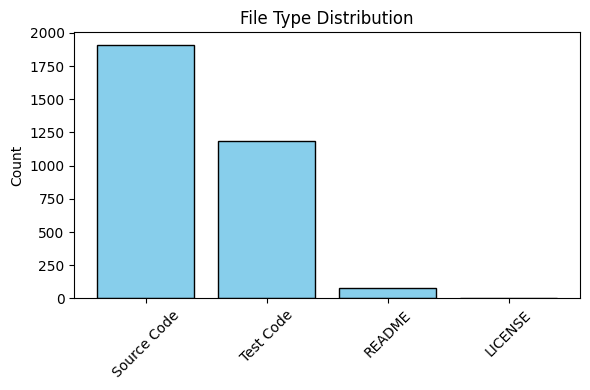

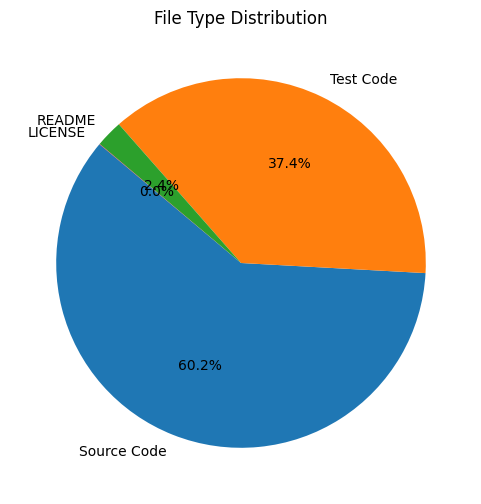

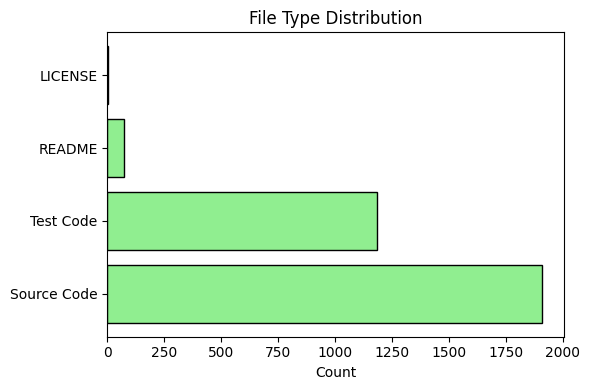

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "File Type": ["Source Code", "Test Code", "README", "LICENSE"],
    "Count": [1909, 1184, 75, 1]
}
df = pd.DataFrame(data)

plt.figure(figsize=(6,4))
plt.bar(df["File Type"], df["Count"], color="skyblue", edgecolor="black")
plt.title("File Type Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.pie(df["Count"], labels=df["File Type"], autopct='%1.1f%%', startangle=140)
plt.title("File Type Distribution")
plt.show()

plt.figure(figsize=(6,4))
plt.barh(df["File Type"], df["Count"], color="lightgreen", edgecolor="black")
plt.title("File Type Distribution")
plt.xlabel("Count")
plt.tight_layout()
plt.show()